# Using Saliency Maps for enhancing neural prediction

## Background: 
Prediction of activation pattern of neurons during visual processing  $\Rightarrow$ CNNs are so far the best architectures 

### Idea: 
* prediction of activation in V4 using monkey data.
* V4 is already intermediate processing in the hierarchy of a CNN
* it is probably that saliency has en effect in this stage $\Rightarrow$ use it in the form of a map that shows most fixated parts to enhance prediction

### Saliency: 
fixation on certain parts of a picture that are f.e. more valuable for survival/learning

<img src="images/deepgaze_ex.png"> 
Kümmerer, M., Theis, L., & Bethge, M. (2014). Deep gaze i: Boosting saliency prediction with feature maps trained on imagenet. arXiv preprint arXiv:1411.1045.

### How to calculate saliency maps?

* Deep Gaze: package by Matthias Kümmerer, Lucas Theis and Matthias Bethge
* Deep Gaze uses a pretrained network to generate a high-dim feature space
* then combines network with the data on fixations of the MIT-1003 (a dataset for training and testing saliency)

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np
from scipy.misc import face
import torch
import torchvision
import torchvision.transforms as transforms
import os
import gc  #for collecting garbage memory storage

# Setup

Make sure you have the following prerequisites:
* pysaliency (https://github.com/matthias-k/pysaliency)
* deepgaze_pytorch (https://github.com/matthias-k/deepgaze_pytorch)
* checkpoints for
    * [DeepGaze II](https://nc.mlcloud.uni-tuebingen.de/index.php/s/9RFfwrRmHq2sL5D). Actually, this is a slightly improved version of DeepGaze II
    * [DeepGaze III](https://nc.mlcloud.uni-tuebingen.de/index.php/s/KK9WZgWRLcdzwoG)

torch.Size([1120, 1279])

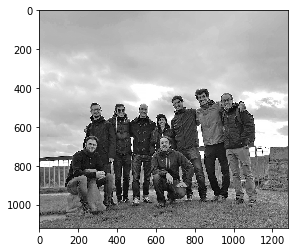

In [6]:
from PIL import Image

os.chdir('/notebooks/notebooks/Katharina')
image = Image.open('images/sinzgroup.png')
imsize = 500

loader = transforms.Compose([
    #transforms.Resize(imsize),
    transforms.ToTensor()])  

image_tens =   loader(image).unsqueeze(0)


image = image_tens.cpu().clone().squeeze(0).permute(1,2,0).numpy()

#brings pixel values into the range between 0 and 255
image = ((image - image.min()) * (1/(image.max() - image.min()) * 255)).astype('uint8')

plt.imshow(image)

centerbias = np.zeros(image_tens.squeeze(0).size()[1:3])

image_tens.squeeze(0).size()[1:3]

In [7]:

os.chdir('/notebooks/deepgaze/deepgaze_pytorch')

In [8]:
from deepgaze_pytorch import load_pytorch_model_from_experiment

ModuleNotFoundError: No module named 'pysaliency'

# DeepGaze II

In [9]:
gc.collect()
torch.cuda.empty_cache()

deepgaze_2 = load_pytorch_model_from_experiment(
    experiment_directory='experiments/experiment0051_DeepGazeII_average_image/',
    training_part='MIT1003',
    crossval_fold=0,
)

NameError: name 'load_pytorch_model_from_experiment' is not defined

In [6]:
image_tens = None
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())

80219648


In [7]:
gc.collect()
torch.cuda.empty_cache()

log_density = deepgaze_2.forward(
    x=torch.tensor([image.transpose(2, 0, 1)], dtype=torch.float32).to('cuda')
    ,centerbias=torch.tensor([centerbias]).to('cuda')
).clone().detach().cpu().numpy()

log_density_torch = deepgaze_2.forward(
    x=torch.tensor([image.transpose(2, 0, 1)], dtype=torch.float32).to('cuda')
    ,centerbias=torch.tensor([centerbias]).to('cuda')
).clone().detach().cpu()

print(log_density)

[[[-16.96617823 -16.96617823 -16.96617823 ... -16.72413717 -16.72413717
   -16.72413717]
  [-16.96617823 -16.96617823 -16.96617823 ... -16.72413717 -16.72413717
   -16.72413717]
  [-16.96617823 -16.96617823 -16.96617823 ... -16.72413717 -16.72413717
   -16.72413717]
  ...
  [-17.54975455 -17.54975455 -17.54975455 ... -17.32734476 -17.32734476
   -17.32734476]
  [-17.54975455 -17.54975455 -17.54975455 ... -17.32734476 -17.32734476
   -17.32734476]
  [-17.54975455 -17.54975455 -17.54975455 ... -17.32734476 -17.32734476
   -17.32734476]]]


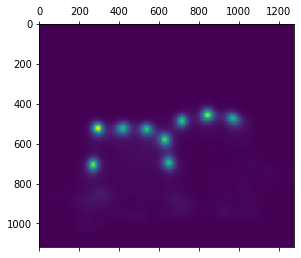

In [8]:
plt.matshow(np.exp(log_density.squeeze(0)))


import torchvision.utils as utils
utils.save_image(torch.exp(log_density_torch.squeeze(0)), "/notebooks/notebooks/Katharina/images/deepgaze2.jpg")

# DeepGaze III

In [9]:
print(torch.cuda.memory_allocated())

#delete none necessary objects to get gpu memory back:
log_density = None
deepgaze_2 = None
gc.collect()
torch.cuda.empty_cache()

print(torch.cuda.memory_allocated())
deepgaze_3 = load_pytorch_model_from_experiment(
    experiment_directory='experiments/experiment0047_DG3_average_image',
    training_part='MIT1003',
    crossval_fold=0,
)

94555648
0
Targets are ['conv5_1', 'relu5_1', 'relu5_2', 'conv5_3', 'relu5_4']
Remaining training parameters
saliency_network.layernorm0.weight
saliency_network.layernorm0.bias
saliency_network.conv0.weight
saliency_network.bias0.bias
saliency_network.layernorm1.weight
saliency_network.layernorm1.bias
saliency_network.conv1.weight
saliency_network.bias1.bias
saliency_network.layernorm2.weight
saliency_network.layernorm2.bias
saliency_network.conv2.weight
saliency_network.bias2.bias
scanpath_network.layernorm0.weight
scanpath_network.layernorm0.bias
scanpath_network.conv0.weight
scanpath_network.bias0.bias
scanpath_network.layernorm1.weight
scanpath_network.layernorm1.bias
scanpath_network.conv1.weight
scanpath_network.bias1.bias
fixation_selection_network.layernorm0.layernorm_part0.weight
fixation_selection_network.layernorm0.layernorm_part0.bias
fixation_selection_network.layernorm0.layernorm_part1.weight
fixation_selection_network.layernorm0.layernorm_part1.bias
fixation_selection_ne

In [10]:
# conditional prediction conditioned on a last saccade from
# xy=(800, 600) to xy=(400, 500). So the eye is currently fixating
# xy=(400, 500). Notice that the last two fixations have to be given backward!

print(torch.cuda.memory_allocated())
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())

log_density = deepgaze_3.forward(
    x=torch.tensor([image.transpose(2, 0, 1)], dtype=torch.float32).to('cuda'),
    centerbias=torch.tensor([centerbias]).to('cuda')
    ,x_hist=torch.tensor([[400, 800]]).to('cuda'),
    y_hist=torch.tensor([[500, 600]]).to('cuda'),
).detach().cpu().numpy()[0]

80243200
80243200


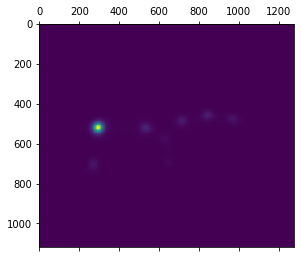

In [11]:
plt.matshow(np.exp(log_density))
#plt.arrow(x=800, y=600, dx=-400, dy=-100, width=10, length_includes_head=True)

In [12]:
log_density

array([[-19.46248531, -19.46248531, -19.46248531, ..., -23.45873021,
        -23.45873021, -23.45873021],
       [-19.46248531, -19.46248531, -19.46248531, ..., -23.45873021,
        -23.45873021, -23.45873021],
       [-19.46248531, -19.46248531, -19.46248531, ..., -23.45873021,
        -23.45873021, -23.45873021],
       ...,
       [-19.27206009, -19.27206009, -19.27206009, ..., -21.24888467,
        -21.24888467, -21.24888467],
       [-19.27206009, -19.27206009, -19.27206009, ..., -21.24888467,
        -21.24888467, -21.24888467],
       [-19.27206009, -19.27206009, -19.27206009, ..., -21.24888467,
        -21.24888467, -21.24888467]])